In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

import os
import json
import time

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

import torch

import config

from tokenizer.tokenizer import ByteLevelBPE, TokenizerHF

import importlib

from model.CPTR_upd import CPTR

from model.helpers import *

from dataset.loader import DatasetLoader

/home/nad/studies/Transformer-Image-Captioning-IIW/.env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
importlib.reload(config)
torch.cuda.empty_cache()

In [3]:
batch_size_train = config.BATCH_SIZE_TRAIN
batch_size_test = config.BATCH_SIZE_TEST

H = config.IMG_HEIGHT
W = config.IMG_WIDTH
P = config.PATCH_SIZE
D_IMG = config.IMG_EMBEDDING_DIM

# The data will get truncated/padded to this length AFTER tokenization
L = config.MAX_TEXT_SEQUENCE_LENGTH
D_TEXT = config.TEXT_EMBEDDING_DIM
DROPOUT_DEC = config.DECODER_DROPOUT_PROB

In [4]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

random.seed(42)

## Build Dataset

In [5]:
data_loader = DatasetLoader(dataset_type=config.DATASET, batch_size_train=batch_size_train, batch_size_test=batch_size_test, shuffle_test=True)
data_loader.load_data()

train_dataloader = data_loader.get_train_dataloader()
test_dataloader = data_loader.get_test_dataloader()

Loading Flickr30k dataset...
DatasetDict({
    test: Dataset({
        features: ['image', 'description'],
        num_rows: 31014
    })
})


Number of training samples: 24811
Number of test samples: 6203
torch.Size([16, 3, 224, 224])
Caption: A little boy skateboarder is doing a trick on his board while another young skateboarder watches.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3262744].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.5528543].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.3060222].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2317834].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.39599

torch.Size([16, 3, 224, 224])
Caption: Shirtless young man rock climbing up the face of cliff looking for the next handhold.
torch.Size([16, 3, 224, 224])
Caption: A woman with a red purse and a dark colored coat is walking along a city street while talking on a cellphone.
torch.Size([16, 3, 224, 224])
Caption: A seated man in a blue T-shirt and green cap rests against divider glass in a train car.
torch.Size([16, 3, 224, 224])
Caption: A man in orange vest with a rifle in one hand and a dead bird in the other smiling.
torch.Size([16, 3, 224, 224])
Caption: A man in a black t-shirt is holding a pool cue next to a pool table with the cue ball on it while another man in a gray hat gives him directions.
torch.Size([16, 3, 224, 224])
Caption: This is an Asian man in the 2012 olympics, whom is weightlifting.
torch.Size([16, 3, 224, 224])
Caption: A group of young Asian people wave their hands in the air.
torch.Size([16, 3, 224, 224])
Caption: Two men wear funny looking black suits while cli

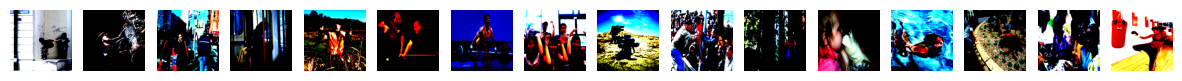

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.7457983].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5630252..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].
Clip

torch.Size([24, 3, 224, 224])
Caption: Three people are standing by the store and the owner is sitting inside of the store
torch.Size([24, 3, 224, 224])
Caption: Skateboarder does tricks in front of crowd while photographer watches
torch.Size([24, 3, 224, 224])
Caption: 12 family photos on a shelf with a yellow, red, green, and purple flower wreath in front of it.
torch.Size([24, 3, 224, 224])
Caption: Three young Asian women walk on a rain soaked street with traffic in the background.
torch.Size([24, 3, 224, 224])
Caption: The girl in a purple sweater performs on her guitar and passersby stop to listen.
torch.Size([24, 3, 224, 224])
Caption: Several people are walking on a street and there is a large, blue crane towering and leaning against a building.
torch.Size([24, 3, 224, 224])
Caption: USA basketball player dribbling to the basket protecting the ball from the opposition.
torch.Size([24, 3, 224, 224])
Caption: A man in an orangutan suit has a conversation with an older man in a ye

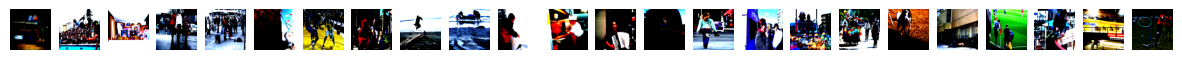

In [6]:
# dataset stats
print(f"Number of training samples: {len(train_dataloader.dataset)}")
print(f"Number of test samples: {len(test_dataloader.dataset)}")

# plot some samples from the dataset
data_iter = iter(test_dataloader)
batch = next(data_iter)
image_tensor = batch['pixel_values']
captions = batch['description']
fig, axs = plt.subplots(1, batch_size_test, figsize=(15, 5))
for i in range(batch_size_test):
    print(image_tensor.shape)
    img = image_tensor[i].cpu().permute(1, 2, 0).numpy()
    print('Caption:', captions[i])
    axs[i].imshow(img)
    axs[i].axis('off')
plt.show()

data_iter = iter(train_dataloader)
batch = next(data_iter)
image_tensor = batch['pixel_values']
captions = batch['description']
fig, axs = plt.subplots(1, batch_size_train, figsize=(15, 5))
for i in range(batch_size_train):
    print(image_tensor.shape)
    img = image_tensor[i].cpu().permute(1, 2, 0).numpy()
    print('Caption:', captions[i])
    axs[i].imshow(img)
    axs[i].axis('off')
plt.show()

## Initialize Tokenizer

In [7]:
special_tokens = [config.SpecialTokens.PAD, config.SpecialTokens.BOS, config.SpecialTokens.EOS]
if config.TOKENIZER_TYPE == config.TokenizerType.HF:
    tokenizer = TokenizerHF()
elif config.TOKENIZER_TYPE == config.TokenizerType.BPE:
    tokenizer = ByteLevelBPE(special_tokens=special_tokens)
    tokenizer.load(folder=config.TOKENIZER_DATA_PATH, filename_prefix=config.TOKENIZER_FILENAME_PREFIX)
pad_idx = tokenizer.get_padding_token_id()
vocab_size = tokenizer.get_vocab_size()
print(f"Tokenizer vocab size: {vocab_size}")

Tokenizer vocab size: 9965


## Configure Model

In [8]:
transformer = CPTR(num_patches=config.NUM_PATCHES,
                   img_emb_dim=D_IMG,
                   patch_size=P,
                   text_emb_dim=D_TEXT,
                   d_model=D_TEXT,
                   max_text_seq_len=L,
                   vocab_size=vocab_size,
                   pad_idx=pad_idx,
                   verbose=False).to(device)

Initialized ViT Encoder: google/vit-base-patch16-224-in21k


## Training code

In [9]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               scheduler: torch.optim.lr_scheduler._LRScheduler,
               device: torch.device, epoch=None, verbose=False) -> Tuple[float, float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()
    # optimizer.zero_grad()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    pad_idx=tokenizer.get_padding_token_id()

    # Loop through data loader data batches
    for batch in dataloader:
        images = batch["pixel_values"].to(device)
        texts = batch["description"]

        outputs = tokenizer.encode_batched(texts=texts, max_seq_length=(L+1))
        tokens = outputs['input_ids']
        tokens = tokens.to(device)

        targets = tokens[:, 1:]
        decoder_inputs = tokens[:, :-1]
        T = decoder_inputs.size(1)
        attention_mask = get_causal_mask(T, device=device)
        padding_mask = get_padding_mask(decoder_inputs, pad_idx, device=device)

        logits, loss = model(images=images, text_tokens=decoder_inputs, attn_mask=attention_mask, pad_mask=padding_mask, targets=targets)

        # B, T, V = logits.shape
        # loss = loss_fn(
        #     logits.reshape(-1, V),
        #     targets.reshape(-1)
        # ) # my CPTR
        train_loss += loss.item()

        # optimizer.zero_grad()
        # loss.backward()
        # optimizer.step()
        
        optimizer.zero_grad()
        loss.backward()
        
        # Clip gradients to a max norm of 1.0
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        with torch.no_grad():
            preds = logits.argmax(dim=-1)
            pad_idx = tokenizer.get_padding_token_id()
            non_pad = targets != pad_idx
            acc = ((preds == targets) & non_pad).sum() / non_pad.sum()
            train_acc += acc.item()
        
        if verbose:
            with torch.no_grad():
                # print produced tokens for debugging
                if epoch is not None and config.NUM_EPOCHS - epoch <= 1:  # print only for last 2 epochs
                    decoded_preds = tokenizer.decode_batched(preds) #[tokenizer.decode(preds[i].cpu().numpy()) for i in range(preds.size(0))]
                    decoded_targets = tokenizer.decode_batched(targets) #[tokenizer.decode(targets[i].cpu().numpy()) for i in range(targets.size(0))]
                    for dp, dt in zip(decoded_preds, decoded_targets):
                        print(f"Predicted: {dp} | Target: {dt}")
    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_perplexity = torch.exp(torch.tensor(train_loss)).item()
    train_acc = train_acc / len(dataloader)
    return train_loss, train_perplexity, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device, epoch=None, verbose=False) -> Tuple[float, float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    pad_idx = tokenizer.get_padding_token_id()

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch in dataloader:
          images = batch["pixel_values"].to(device)
          texts = batch["description"]

          outputs = tokenizer.encode_batched(texts=texts, max_seq_length=(L+1))
          tokens = outputs['input_ids']
          tokens = tokens.to(device)
          tokens = tokens.to(device)

          targets = tokens[:, 1:]
          decoder_inputs = tokens[:, :-1]
          T = decoder_inputs.size(1)
          attention_mask = get_causal_mask(T, device=device)
          padding_mask = get_padding_mask(decoder_inputs, pad_idx, device=device)
        
          logits, loss = model(images=images, text_tokens=decoder_inputs, attn_mask=attention_mask, pad_mask=padding_mask, targets=targets)

          # B, T, V = logits.shape
          # loss = loss_fn(
          #     logits.reshape(-1, V),
          #     targets.reshape(-1)
          # )
          test_loss += loss.item()

          preds = logits.argmax(dim=-1)
          pad_idx = tokenizer.get_padding_token_id()
          non_pad = targets != pad_idx
          acc = ((preds == targets) & non_pad).sum() / non_pad.sum()
          test_acc += acc.item()
          
          if verbose:
            # print produced tokens for debugging
            if epoch is not None and config.NUM_EPOCHS - epoch <= 1:  # print only for last 2 epochs
              decoded_preds = tokenizer.decode_batched(preds)
              decoded_targets = tokenizer.decode_batched(targets)
              for dp, dt in zip(decoded_preds, decoded_targets):
                  print(f"Predicted: {dp} | Target: {dt}")

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_perplexity = torch.exp(torch.tensor(test_loss)).item()
    test_acc = test_acc / len(dataloader)
    return test_loss, test_perplexity, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          scheduler: torch.optim.lr_scheduler._LRScheduler,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_perplexity: [...],
              train_acc: [...],
              test_loss: [...],
              test_perplexity: [...],
              test_acc: [...]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_perplexity": [],
               "train_acc": [],
               "test_loss": [],
               "test_perplexity": [],
               "test_acc": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_perplexity, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          scheduler=scheduler,
                                          device=device,
                                          epoch=epoch)
        test_loss, test_perplexity, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device,
          epoch=epoch)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_perplexity: {train_perplexity:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_perplexity: {test_perplexity:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_perplexity"].append(train_perplexity)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_perplexity"].append(test_perplexity)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [10]:
# freeze encoder weights
def config_encoder_params(model, requires_grad: bool):
    if config.ENCODER_ARCH == config.EncoderArch.CNN_RESNET50:
        for param in model.encoder.parameters():
            param.requires_grad = requires_grad
    elif config.ENCODER_ARCH == config.EncoderArch.VIT_STYLE_BASE or config.ENCODER_ARCH == config.EncoderArch.VIT_STYLE_LARGE:
        for param in model.encoder.parameters():
            param.requires_grad = requires_grad
    elif config.ENCODER_ARCH == config.EncoderArch.CNN_CPTR_STYLE:
        for param in model.encoder.feature_extractor.parameters():
            param.requires_grad = requires_grad

# def get_optimizer(model, lr, enc_factor):
#     # Standard parameters (Decoder, Projection, etc.)
#     base_params = [p for n, p in model.named_parameters() if "encoder" not in n]
#     print('base_params_names:', [n for n, p in model.named_parameters() if "encoder" not in n])
#     # Pretrained parameters (ResNet or ViT)
#     encoder_params = [p for n, p in model.named_parameters() if "encoder" in n]
#     print('encoder_params_names:', [n for n, p in model.named_parameters() if "encoder" in n])

#     return torch.optim.AdamW([
#         {'params': base_params, 'lr': lr},
#         {'params': encoder_params, 'lr': lr * enc_factor}
#     ], weight_decay=0.01)

In [11]:
# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=pad_idx, label_smoothing=config.LABEL_SMOOTHING) # ignore the padding token for loss calculation

if config.NUM_FREEZE_EPOCHS > 0:
    config_encoder_params(transformer, requires_grad=False)
    # optimizer = get_optimizer(transformer, lr=config.LR, enc_factor=0.0) # freeze encoder
    
    optimizer = torch.optim.AdamW(
        [p for p in transformer.parameters() if p.requires_grad],
        lr=config.LR,
        weight_decay=0.01
    )
    
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=config.LR, 
        steps_per_epoch=len(train_dataloader), 
        epochs=config.NUM_FREEZE_EPOCHS,
        pct_start=0.1 # 10% of time spent warming up
    )

In [12]:
# Check which parameters require gradients
params_with_grad = {name: param for name, param in transformer.named_parameters() if param.requires_grad}
print("Parameters requiring gradients:")
for name, param in params_with_grad.items():
    print(f"{name}: {param.shape}")

Parameters requiring gradients:
emb_projector.projection.weight: torch.Size([512, 768])
emb_projector.layernorm.weight: torch.Size([512])
emb_projector.layernorm.bias: torch.Size([512])
decoder.word_embedding.embedding.weight: torch.Size([9965, 512])
decoder.text_layernorm.weight: torch.Size([512])
decoder.text_layernorm.bias: torch.Size([512])
decoder.decoder_blocks.0.MMHSA.in_proj_weight: torch.Size([1536, 512])
decoder.decoder_blocks.0.MMHSA.out_proj.weight: torch.Size([512, 512])
decoder.decoder_blocks.0.layer_norm_1.weight: torch.Size([512])
decoder.decoder_blocks.0.layer_norm_1.bias: torch.Size([512])
decoder.decoder_blocks.0.MHCA.in_proj_weight: torch.Size([1536, 512])
decoder.decoder_blocks.0.MHCA.out_proj.weight: torch.Size([512, 512])
decoder.decoder_blocks.0.layer_norm_2.weight: torch.Size([512])
decoder.decoder_blocks.0.layer_norm_2.bias: torch.Size([512])
decoder.decoder_blocks.0.FFN.0.weight: torch.Size([2048, 512])
decoder.decoder_blocks.0.FFN.3.weight: torch.Size([512, 

In [ ]:
if config.NUM_FREEZE_EPOCHS > 0:
    # Train the model for freezing phase
    results = train(model=transformer,
                           train_dataloader=train_dataloader,
                           test_dataloader=test_dataloader,
                           optimizer=optimizer,
                           scheduler=scheduler,
                           loss_fn=loss_fn,
                           epochs=config.NUM_FREEZE_EPOCHS,
                           device=device)
    print('Completed freezing phase.')

 20%|██        | 1/5 [06:18<25:12, 378.05s/it]

Epoch: 1 | train_loss: 3.8801 | train_perplexity: 48.4280 | train_acc: 0.3281 | test_loss: 2.6977 | test_perplexity: 14.8454 | test_acc: 0.4324


In [ ]:
config_encoder_params(transformer, requires_grad=True)

# for i, group in enumerate(optimizer.param_groups):
#     print(f"Group {i} starting LR: {group['lr']}")

# optimizer.param_groups[1]['lr'] = config.LR * 0.1

optimizer = torch.optim.AdamW(
    [
        {
            'params': [p for n, p in transformer.named_parameters() if "encoder" not in n],
            'lr': config.LR
        },
        {
            'params': [p for n, p in transformer.named_parameters() if "encoder" in n],
            'lr': config.LR * 0.1
        }
    ],
    weight_decay=0.01
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=config.NUM_EPOCHS,
    eta_min=1e-7
)

In [ ]:
# Recheck which parameters require gradients
params_with_grad = {name: param for name, param in transformer.named_parameters() if param.requires_grad}
print("Parameters requiring gradients:")
for name, param in params_with_grad.items():
    print(f"{name}: {param.shape}")

Parameters requiring gradients:
encoder.vit.embeddings.cls_token: torch.Size([1, 1, 768])
encoder.vit.embeddings.position_embeddings: torch.Size([1, 197, 768])
encoder.vit.embeddings.patch_embeddings.projection.weight: torch.Size([768, 3, 16, 16])
encoder.vit.embeddings.patch_embeddings.projection.bias: torch.Size([768])
encoder.vit.encoder.layer.0.attention.attention.query.weight: torch.Size([768, 768])
encoder.vit.encoder.layer.0.attention.attention.query.bias: torch.Size([768])
encoder.vit.encoder.layer.0.attention.attention.key.weight: torch.Size([768, 768])
encoder.vit.encoder.layer.0.attention.attention.key.bias: torch.Size([768])
encoder.vit.encoder.layer.0.attention.attention.value.weight: torch.Size([768, 768])
encoder.vit.encoder.layer.0.attention.attention.value.bias: torch.Size([768])
encoder.vit.encoder.layer.0.attention.output.dense.weight: torch.Size([768, 768])
encoder.vit.encoder.layer.0.attention.output.dense.bias: torch.Size([768])
encoder.vit.encoder.layer.0.interme

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Train the model for the rest of the epochs and save the training results to a dictionary
results = train(model=transformer,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       scheduler=scheduler,
                       loss_fn=loss_fn,
                       epochs=config.NUM_EPOCHS,
                       device=device)
print('Completed training.')

100%|██████████| 1/1 [11:48<00:00, 708.20s/it]

Epoch: 1 | train_loss: 2.6000 | train_perplexity: 13.4639 | train_acc: 0.4494 | test_loss: 2.4693 | test_perplexity: 11.8144 | test_acc: 0.4708
Completed training.


In [ ]:
# export training results to results directory
results_dir = 'results'
os.makedirs(results_dir, exist_ok=True)
results_path = os.path.join(results_dir, 'training_results.json')
with open(results_path, 'w') as f:
    json.dump(results, f)

time_string = time.strftime("%Y%m%d-%H%M%S")
# export model weights
model_path = os.path.join(results_dir, f'cptr_model_{time_string}.pth')
torch.save(transformer.state_dict(), model_path)

In [ ]:
# ### old training code below

# optimizer = torch.optim.Adam(params=transformer.parameters(),
#                              lr=config.LR,
#                             #  betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
#                              weight_decay=config.WEIGHT_DECAY)

# scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer, 
#     max_lr=config.LR, 
#     steps_per_epoch=len(train_dataloader), 
#     epochs=config.NUM_EPOCHS,
#     pct_start=0.1 # 10% of time spent warming up
# )

# # Setup the loss function for multi-class classification
# loss_fn = torch.nn.CrossEntropyLoss(ignore_index=pad_idx, label_smoothing=config.LABEL_SMOOTHING) # ignore the padding token for loss calculation

# # x = enumerate(train_dataloader)
# # print(next(x))
# # Train the model and save the training results to a dictionary
# results = train(model=transformer,
#                        train_dataloader=train_dataloader,
#                        test_dataloader=test_dataloader,
#                        optimizer=optimizer,
#                        scheduler=scheduler,
#                        loss_fn=loss_fn,
#                        epochs=config.NUM_EPOCHS,
#                        device=device)

In [ ]:
# # export training results to results directory
# results_dir = 'results'
# os.makedirs(results_dir, exist_ok=True)
# results_path = os.path.join(results_dir, 'training_results.json')
# with open(results_path, 'w') as f:
#     json.dump(results, f)

# time_string = time.strftime("%Y%m%d-%H%M%S")
# # export model weights
# model_path = os.path.join(results_dir, f'cptr_model_{time_string}.pth')
# torch.save(transformer.state_dict(), model_path)

## Test caption generation

In [24]:
model_path = 'results/cptr_model_20260119-050449.pth'
transformer = CPTR(num_patches=config.NUM_PATCHES,
                   img_emb_dim=D_IMG,
                   patch_size=P,
                   text_emb_dim=D_TEXT,
                   d_model=D_TEXT,
                   max_text_seq_len=L,
                   vocab_size=vocab_size,
                   pad_idx=pad_idx,
                   verbose=False).to(device)
transformer.load_state_dict(torch.load(model_path, map_location=device))

Initialized ViT Encoder: google/vit-base-patch16-224-in21k


<All keys matched successfully>

In [55]:
transformer.eval()

batch = next(iter(train_dataloader))
image = batch["pixel_values"][0].unsqueeze(0).to(device)
print('Caption GT: ', batch["description"][0])
print('Input image shape:', image.shape)
tokens = transformer.generate(image, 
        bos_token=tokenizer.get_vocab()[config.SpecialTokens.BOS.value],
        eos_token=tokenizer.get_vocab()[config.SpecialTokens.EOS.value],
        max_len=L,
        device=device)
if not isinstance(tokens, torch.Tensor):
        tokens = torch.tensor(tokens)
print('Generated token ids:', tokens)
print(tokens.shape)
decoded_caption = tokenizer.decode(tokens)
print('Generated caption:', decoded_caption)

Caption GT:  A woman playing guitar and singing in the foreground and three others performing behind her.
Input image shape: torch.Size([1, 3, 224, 224])
Generated token ids: tensor([   1,   68,  303,  270,  259,  333,  262,  271,  117,  119,  259, 4035,
         333,  273,  267,  326,  297,  379,  270, 1970,  113,  119,  292,  259,
         277,  280,  122,  103,  292,  369,   49,    2])
torch.Size([32])
Generated caption: <bos>A man in a black shirt and black pants is standing in front of a crowd of people.<eos>


In [23]:
from model.other_CPTR import ImageCaptionModel

device = 'cpu'
configuration['device'] = device
configuration['gpt_kwargs']['device'] = device
configuration['vit_kwargs']['device'] = device
# load exported model weights for inference
model_path = 'results/cptr_model_20260118-032850.pth'
transformer = ImageCaptionModel(configuration).to(device)
transformer.load_state_dict(torch.load(model_path, map_location=device))

transformer.eval()

batch = next(iter(train_dataloader))
image = batch["pixel_values"][0].unsqueeze(0).to(device)
print('Input image shape:', image.shape)
tokens = transformer.generate(image, 
        sos_token=tokenizer.get_vocab()[config.SpecialTokens.BOS.value],
        eos_token=tokenizer.get_vocab()[config.SpecialTokens.EOS.value],
        max_len=L)
decoded_caption = tokenizer.decode(tokens)
print('Generated caption:', decoded_caption)

ModuleNotFoundError: No module named 'model.other_CPTR'

In [ ]:
@torch.no_grad()
def generate_caption(model, image, tokenizer, max_length=config.MAX_TEXT_SEQUENCE_LENGTH, device='cuda'):
    model.eval()
    with torch.inference_mode():
        # 1. Encode the image once (K, V)
        # image shape: [1, 3, H, W]
        img_features = model.forward_images(image.to(device))

        # 2. Start with the [BOS] token
    # current_tokens shape: [1, 1]
    bos_idx = tokenizer.token_to_id(config.SpecialTokens.BOS)
    eos_idx = tokenizer.token_to_id(config.SpecialTokens.EOS)
    current_tokens = torch.tensor([[bos_idx]], device=device)
    
    generated_ids = [bos_idx]

    with torch.inference_mode():
        for i in range(max_length):
            # 3. Generate the causal mask for the current sequence length
            # Standard triangular mask: (L, L)
            sz = current_tokens.size(1)
            # mask = get_attention_mask(decoder_inputs=current_tokens, pad_idx=pad_idx, seq_len=sz, device=device)
            attn_mask = get_causal_mask(sz, device=device)
            padding_mask = get_padding_mask(current_tokens, pad_idx, device=device)

            # 4. Get predictions (Q)
            # We only care about the very last token predicted
            print('Current tokens:', current_tokens)
            decoder_output = model.forward_text(current_tokens, img_features, attn_mask=attn_mask, pad_mask=padding_mask)
            token_logits = model.linear(decoder_output)  # shape: [1, T, V]
            print('Token logits shape: ', token_logits.shape)
            next_token_logits = token_logits[:, -1, :]
            # next_token_logits = model.linear(logits[:, -1, :])
            # print('Token Logits shape:', token_logits.shape)
            preds = next_token_logits.argmax(dim=-1).item()
            print('Predicted token IDs:', preds)
            decoded_preds = tokenizer.decode([preds])
            print(f'Predicted: {decoded_preds}')
            next_token = preds

            # 5. Greedy selection: take the most likely token
            # next_token = torch.argmax(next_token_logits, dim=-1).item()
            
            # print 10 most likely tokens at each step
            topk = 10
            topk_probs, topk_indices = torch.topk(torch.softmax(next_token_logits, dim=-1), k=topk, dim=-1)
            print(f'Step {i+1}:')
            for rank in range(topk):
                token_id = topk_indices[0, rank].item()
                token_str = tokenizer.decode([token_id])
                prob = topk_probs[0, rank].item()
                print(f'  Rank {rank+1}: Token ID {token_id} ("{token_str}") with probability {prob:.4f}')
            
            generated_ids.append(next_token)

            # 6. Stop if [EOS] is reached
            if next_token == eos_idx:
                break

            # 7. Append and continue
            # debug: append random token
            next_token = random.randint(0, 1002)
            current_tokens = torch.tensor([[next_token]], device=device) #torch.cat([current_tokens, torch.tensor([[next_token]], device=device)], dim=1)

    # 8. Convert IDs back to words
    caption = tokenizer.decode(generated_ids)
    return caption

In [ ]:
batch = next(iter(train_dataloader))
image = batch["pixel_values"][0]
print('description: ', batch['description'][0])

generate_caption(transformer, image.unsqueeze(0), tokenizer, max_length=L, device=device)

# # Check which parameters require gradients
# params_with_grad = {name: param for name, param in transformer.named_parameters() if param.requires_grad}
# print("Parameters requiring gradients:")
# for name, param in params_with_grad.items():
#     print(f"{name}: {param.shape}")